<a href="https://colab.research.google.com/github/BucketofJava/Generative-Emotion-Network/blob/main/ResearchProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np

In [ ]:
import pandas as pd
pd.set_option('display.width', 17000)
df=pd.read_csv("emotion-labels-train.csv");
df=df.sample(n=8)

df.head(n=8)


# Import and format text and emotion data

In [ ]:
whitelistchars=['\n', ' ', '!', '"', "'", ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '\\', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 
                'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '\xa0', '£', '´', '»', 'é', 'ñ', 'ó','–', '—', '―', '‘', '’', '“', '”', '•', '…', '‼', '™']

In [ ]:
texts=[]
emotions=[]
emotionlabels=[]
emotionlist=["joy", "sadness", "anger", "fear"]
f=open("/content/emotion-labels-train.csv", "r")
current_line=f.readline()
def processtweet(tweet):
  twot=tweet.split(" ")
  toremove=[]
  hashtags=[]
  for i in range(len(twot)):
    blacklistedchars="#$%^&*()_+{}[]"
    if("@" in twot[i]):
      toremove.append(i)
    if("#" in twot[i]):
      hashtags.append(i)
    else:
      hashtags=[]
    for j in twot[i]:
      if(not j.lower() in whitelistchars):
        blacklistedchars=blacklistedchars+j
    for j in blacklistedchars:
      twot[i]=twot[i].replace(j, '')
  toremove=toremove+hashtags
  for i in range(len(toremove)):
    twot.pop(toremove[i]-i)
  return " ".join(twot)
while("," in current_line):
  row=current_line.split(",")
  labelname=row[len(row)-1].lower().replace(" ", "").replace("\n", "")
  if(not labelname in emotionlist):
    current_line=f.readline()
    continue
  texts.append(processtweet(",".join(row[:len(row)-1])))
  emotionlabels.append(row[len(row)-1].lower().replace(" ", "").replace("\n", ""))
  emotions.append(emotionlist.index(row[len(row)-1].lower().replace(" ", "").replace("\n", "")))
  current_line=f.readline()
f.close()
f=open("/content/emotion-labels-test.csv")
current_line=f.readline()
while("," in current_line):
  row=current_line.split(",")
  labelname=row[len(row)-1].lower().replace(" ", "").replace("\n", "")
  if(not labelname in emotionlist):
    current_line=f.readline()
    continue
  texts.append(processtweet(",".join(row[:len(row)-1])))
  emotionlabels.append(row[len(row)-1].lower().replace(" ", "").replace("\n", ""))
  emotions.append(emotionlist.index(row[len(row)-1].lower().replace(" ", "").replace("\n", "")))
  current_line=f.readline()
f.close()                                                                                                                                                                                                                                                                                                                                                                    
#index=int(len(texts)*.8)
print(len(emotions))
from keras.utils.np_utils import to_categorical
emotions = to_categorical(emotions)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

texts_new=texts.copy()
for i in range(len(texts)):
  endstring="ENDTOKEN"
  if(not texts[i][len(texts[i])-1]==" "):
    endstring=" ENDTOKEN"
  texts_new[i]="STARTOKEN "+texts[i]+endstring;
gen_tokenizer=Tokenizer(num_words=10000)
gen_tokenizer.fit_on_texts(texts_new);
token_sequences=gen_tokenizer.texts_to_sequences(texts_new);
token_list_states=[]
token_actions=[]
gan_list_states=[]
gan_classification_onehots=[]
gan_actions=[]
classification_onehots=[]
for token_sequence_index in range(len(token_sequences)):
  token_sequence=token_sequences[token_sequence_index]

  for i in range(1, len(token_sequence)):
    token_list_states.append(token_sequence[:i])
    classification_onehots.append(emotions[token_sequence_index])
    token_actions.append([token_sequence[i]])
    if(i+1>=len(token_sequence)):
      gan_list_states.append(token_sequence[:i])
     # print(token_sequence)
      gan_classification_onehots.append(emotions[token_sequence_index])
      gan_actions.append([token_sequence[i]])
token_list_states=np.array(pad_sequences(token_list_states, maxlen=64))
gan_list_states=np.array(pad_sequences(gan_list_states, maxlen=64))
classification_onehots=np.array(classification_onehots)
gan_classification_onehots=np.array(gan_classification_onehots)
print(gen_tokenizer.word_index)
token_actions=to_categorical(np.stack(token_actions, axis=0), num_classes=len(gen_tokenizer.word_index))
gan_actions=to_categorical(np.stack(gan_actions, axis=0), num_classes=len(gen_tokenizer.word_index))
print(token_actions)
print(classification_onehots)



#Classifier Model

In [ ]:
x_train=np.array(pad_sequences(token_sequences, maxlen=200))
y_train=np.array(emotions)
shuffled_indices=np.arange(6755)
np.random.shuffle(shuffled_indices)
x_train=x_train[shuffled_indices]
y_train=y_train[shuffled_indices]

In [ ]:

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Maximum, LSTM, GRU, Conv1D, MaxPooling1D, Bidirectional

# print(len(emotionlabels))
# print(len(texts))
# print(x_train)
# print(y_train)
# print(x_train.shape)
# print(y_train.shape)
classifier = Sequential()
classifier.add(Embedding(12844, 100, name="Embedding"))
classifier.add(Conv1D(32, 2, name="Conv1D")) 
classifier.add(Bidirectional(LSTM(100, name="LSTM"), name="Bidirectional"))
classifier.add(Dense(100, activation='relu', name="Dense-ReLU"))
classifier.add(Dense(4, activation='softmax', name="Dense-Softmax"))
classifier.summary()
classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy',
metrics=['acc']) 
stop_index=int(len(x_train)*.95)
# print(stop_index/len(x_train))


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(classifier, show_layer_activations=True, show_layer_names=False, show_shapes=True, rankdir="LR")

In [ ]:
classifier = Sequential()
classifier.add(Embedding(12844, 100))
classifier.add(Conv1D(32, 4, padding="causal")) 
classifier.add(Bidirectional(LSTM(100)))
classifier.add(Dense(100, activation='relu'))
classifier.add(Dense(4, activation='softmax'))
classifier.summary()
classifier.compile(optimizer='rmsprop', 
loss='categorical_crossentropy',
metrics=['acc']) 

In [ ]:
history = classifier.fit(x_train[:stop_index], y_train[:stop_index], 
                         epochs=8, batch_size=32, validation_split=0.05)
score=classifier.evaluate(x_train[stop_index:],
                          y_train[stop_index:])

print(score)

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
#plt.plot(history.history['acc'])
plt.plot([0]+history.history['val_acc'])
plt.ylabel("Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.grid(True)
plt.xlim(1, 8)
plt.ylim(0.5, 0.9)
plt.title("Validation Accuracy Over Training Time")
plt.show()

In [ ]:
from keras.models import save_model
classifier.save("/content/drive/MyDrive/Saved_Models/classifier_model")

In [ ]:
from keras.models import load_model
classifier=load_model("/content/drive/MyDrive/Saved_Models/classifier_model")

In [ ]:
def classify_text(text):
  text=[text]
  text=tokenizer.texts_to_sequences(text)
  text=pad_sequences(text, maxlen=maxlen)
  return emotionlist[classifier.predict(text).argmax()]
def text_probs(text):
  text=[text]
  text=tokenizer.texts_to_sequences(text)
  text=pad_sequences(text, maxlen=maxlen)
  return model.predict(text)
def classify_texts(texts):
  texts=tokenizer.texts_to_sequences(texts)
  texts=pad_sequences(texts, maxlen=maxlen)
  return classifier.predict(texts)
#classify_text("Put something here")
xx=x_train[stop_index:]
yy=y_train[stop_index:]
o=model.predict(xx)
joy=[0, 0]
anger=[0, 0]
sadness=[0, 0]
fear=[0, 0]
emdict={"joy":joy, "anger":anger, "sadness":sadness, "fear":fear}
for i in range(len(o)):
  emdict[emotionlist[yy[i].argmax(axis=0)]][0]=emdict[emotionlist[yy[i].argmax(axis=0)]][0]+1
  if(o[i].argmax(axis=0)==yy[i].argmax(axis=0)):
    emdict[emotionlist[yy[i].argmax(axis=0)]][1]=emdict[emotionlist[yy[i].argmax(axis=0)]][1]+1
print("joy: {}%\nanger: {}%\nsadness: {}%\nfear: {}%".format(joy[1]/joy[0], anger[1]/anger[0], sadness[1]/sadness[0], fear[1]/fear[0]))


In [ ]:
print(classify_text("I hate you"))

anger


In [ ]:
print(classify_text("He was large and menacing"))

fear


In [ ]:
print(classify_text("Life feels meaningless at the moment"))

sadness


In [ ]:
print(classify_text("Today is a beautiful day"))

joy


# Re-tokenize and format data for the generator

In [ ]:
texts_new=texts.copy()
for i in range(len(texts)):
  endstring="ENDTOKEN"
  if(not texts[i][len(texts[i])-1]==" "):
    endstring=" ENDTOKEN"
  texts_new[i]="STARTOKEN "+texts[i]+endstring;
gen_tokenizer=Tokenizer(num_words=10000)
gen_tokenizer.fit_on_texts(texts_new);
token_sequences=gen_tokenizer.texts_to_sequences(texts_new);
token_list_states=[]
token_actions=[]
gan_list_states=[]
gan_classification_onehots=[]
gan_actions=[]
classification_onehots=[]
for token_sequence_index in range(len(token_sequences)):
  token_sequence=token_sequences[token_sequence_index]

  for i in range(1, len(token_sequence)):
    token_list_states.append(token_sequence[:i])
    classification_onehots.append(emotions[token_sequence_index])
    token_actions.append([token_sequence[i]])
    if(i+1>=len(token_sequence)):
      gan_list_states.append(token_sequence[:i])
     # print(token_sequence)
      gan_classification_onehots.append(emotions[token_sequence_index])
      gan_actions.append([token_sequence[i]])
token_list_states=np.array(pad_sequences(token_list_states, maxlen=64))
gan_list_states=np.array(pad_sequences(gan_list_states, maxlen=64))
classification_onehots=np.array(classification_onehots)
gan_classification_onehots=np.array(gan_classification_onehots)
print(gen_tokenizer.word_index)
token_actions=to_categorical(np.stack(token_actions, axis=0), num_classes=len(gen_tokenizer.word_index))
gan_actions=to_categorical(np.stack(gan_actions, axis=0), num_classes=len(gen_tokenizer.word_index))
print(token_actions)
print(classification_onehots)



#Generator Model

In [ ]:
from keras.layers import *

In [ ]:

from keras import Model
classification_label=Input(shape=(4,), name="labels")
classification_result=Dense(64)(classification_label)
token_input=Input(shape=(64,), name="sequences")
token_result=Embedding(len(gen_tokenizer.word_index), 100)(token_input)
token_result=Conv1D(32, 2)(token_result)
token_result=Reshape((63, 32))(token_result)
token_result=GRU(64)(token_result)
concatenated_inputs=Concatenate(axis=1)([classification_result, token_result])
concatenated_inputs=Dense(len(gen_tokenizer.word_index), activation="softmax")(concatenated_inputs)
generator_model=Model(inputs=[classification_label, token_input], outputs=concatenated_inputs)
generator_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

#generator_model.fit(x={"labels":classification_onehots, "sequences":token_list_states}, y=token_actions, validation_split=0.05)

In [ ]:
generator_model.fit(x={"labels":classification_onehots, "sequences":token_list_states}, y=token_actions, validation_split=0.05)

3110/3110 [==============================] - 227s 72ms/step - loss: 6.8605 - acc: 0.0790 - val_loss: 6.3212 - val_acc: 0.0911


In [ ]:
plot_model(generator_model, show_layer_activations=True, show_layer_names=False, show_shapes=True, rankdir="LR")

In [ ]:
generator_model.load_weights("/content/drive/MyDrive/Saved_Models/Feb 28/generator_weights.h5")

In [ ]:
from keras.models import save_model
generator_model.save("/content/drive/MyDrive/Saved_Models/generator_model")

In [ ]:
from keras.models import load_model
generator_model=load_model("/content/drive/MyDrive/Saved_Models/generator_model")

In [ ]:
print(gen_tokenizer)

In [ ]:
s="Emil is "
for i in range(20):
   s+=" "+list(gen_tokenizer.word_index.keys())[roll_index(generator_model.predict(x={"labels":np.array([[0, 0.6, 0.4, 0]]), 
                                  "sequences":pad_sequences(gen_tokenizer.texts_to_sequences([s]), 
                                                            maxlen=64)})[0])]
print(s)


#Define Classes

##Generator Class

In [ ]:
class Generator():
  def __init__(self, generator_model, generator_loss_function, generator_optimizer):
    self.generator_model=generator_model;
    self.generator_loss_function=generator_loss_function;
    self.generator_optimizer=generator_optimizer;
  def pre_train(self, x_data, classification_target, y_data, g_epochs):
    self.generator_model.fit([classification_target, x_data], y_data, epochs=g_epochs)
  def computePolicyGradient(self, states, classification_targets, aprobs, rewards, learning_rate):
    with tf.GradientTape() as tape:
      newaprobs=self.generator_model([classification_targets, states])
      generator_loss=self.generator_loss_function(aprobs*rewards, newaprobs)
      generator_loss+=self.generator_model.losses
    generator_gradient=tape.gradient(generator_loss, self.generator_model.trainable_weights)
    self.generator_optimizer.apply_gradients(zip(generator_gradient, self.generator_model.trainable_weights))
  def getScore(self, classification_targets, sequence_data, y_data):
    return self.generator_model.evaluate({"labels":classification_targets, "sequences":sequence_data}, y_data)
  def generateBatch(self, amount, seed_set=None, g_targets=None):
    seeds=seed_set;
    if(seed_set==None):
      basic_seed=np.zeros(64)
      basic_seed[63]=1;
      basic_seed=np.array([basic_seed])
      seeds=np.repeat(basic_seed, amount, axis=0)
    generator_targets=g_targets
    if(g_targets==None):
      generator_targets=[]
      for i in range(amount):
        generator_targets.append(getRandomProbabilityVector(4));
      generator_targets=np.array(generator_targets)
    #print(seeds.shape)
    #print(generator_targets.shape)
    generator_results=[]
    for i in range(len(seeds)):
      print(i)
      seed=seeds[i] 
      c=0;
      current_sequence=seed[seed!=0]
      
      while c<20:
        generated_token=roll_index(self.generator_model.predict_on_batch({"labels": np.array([generator_targets[i]]), "sequences": pad_sequences([current_sequence], maxlen=64)})[0])
        #print(generated_token)
        if(c>=19):
          generated_token=2
        current_sequence=np.append(current_sequence, generated_token)
        if(generated_token==2):
          break;
        c+=1;
      generator_results.append(current_sequence)
    #print(generator_results)
    generator_results=pad_sequences(np.array(generator_results), maxlen=64)
    return generator_results, generator_targets

##Discriminator Class

In [ ]:
import random
class Discriminator():
  def __init__(self, discriminator_model, discriminator_loss_function, discriminator_optimizer):
    self.discriminator_model=discriminator_model;

    self.discrimnator_loss_function=discriminator_loss_function;
    self.discriminator_optimizer=discriminator_optimizer
  def train(self, real_x, real_y, generator, d_split, d_epochs=1):
    y_tokens=[]
    for i in (real_y):
       y_tokens.append(roll_index(i))
    y_tokens=np.array([y_tokens]).T
    x_data_real=np.concatenate((real_x[1], y_tokens), axis=1)
    x_data_real=np.delete(x_data_real, 0, axis=1)
    x_data_fake=generator.generateBatch(real_x[1].shape[0])[0]
    for i in range(d_epochs):
      real_variance=[]
      fake_variance=[]
      for i in range(int(x_data_real.shape[0])):
        real_variance.append(random.randint(0, 20)/100)
        fake_variance.append(random.randint(0, 20)/100)
      np.random.shuffle(real_variance)
      np.random.shuffle(fake_variance) 
      y_data_real, y_data_fake=np.ones(x_data_real.shape[0])-real_variance, np.zeros(x_data_fake.shape[0])+fake_variance
      current_index=0
      length_fraction_real=int(x_data_real.shape[0]/d_split)
      length_fraction_fake=int(x_data_fake.shape[0]/d_split)
      index_real_previous=0
      index_fake_previous=0
      for i in range(d_split+1):
        index_real=(i*length_fraction_real)+random.randint(0, length_fraction_real)
        index_fake=(i*length_fraction_real)+random.randint(0, length_fraction_fake)
        if(i>=d_split):      
          self.discriminator_model.train_on_batch(x_data_real[index_real_previous:], y_data_real[index_real_previous:])
          self.discriminator_model.train_on_batch(x_data_fake[index_fake_previous:], y_data_fake[index_fake_previous:])
        self.discriminator_model.train_on_batch(x_data_real[index_real_previous:index_real], y_data_real[index_real_previous:index_real])
        self.discriminator_model.train_on_batch(x_data_fake[index_fake_previous:index_fake], y_data_fake[index_fake_previous:index_fake])
  def evaluate_discriminator(self, real_states, real_actions, generator):
    action_tokens=[]
    for i in (real_actions):
       action_tokens.append(roll_index(i))
    action_tokens=np.array([action_tokens]).T
    x_data_real=np.concatenate((real_states, action_tokens), axis=1)
    x_data_real=np.delete(x_data_real, 0, axis=1)
    x_data_fake=generator.generateBatch(x_data_real.shape[0])[0]
    real_variance=pad_sequences([np.ones(int(x_data_real.shape[0]/5))/100], maxlen=x_data_fake.shape[0])[0]
    fake_variance=pad_sequences([np.ones(int(x_data_fake.shape[0]/5))/100], maxlen=x_data_real.shape[0])[0]
    np.random.shuffle(real_variance)
    np.random.shuffle(fake_variance) 
    y_data_real, y_data_fake=np.ones(x_data_real.shape[0])-real_variance, np.zeros(x_data_fake.shape[0])+fake_variance
    y_data=np.concatenate((y_data_real, y_data_fake), axis=0)
    x_data=np.concatenate((x_data_real, x_data_fake), axis=0)
    return self.discriminator_model.evaluate(x_data, y_data);
  def compute_reward(self, sequence):
    print(self.discriminator_model.predict(np.array([sequence]))[0])
    return self.discriminator_model.predict(np.array([sequence]))

#Define Discriminator Model


In [ ]:
#Createas discriminator model
from keras import layers
from keras.models import Sequential
from keras.optimizers import adam_v2
discriminator=Sequential()
discriminator.add(Input(64,))
discriminator.add(layers.Embedding(len(gen_tokenizer.word_index), 100))
discriminator.add(layers.Conv1D(32, 2))
discriminator.add(layers.LSTM(32))
discriminator.add(layers.Dense(32, activation='relu'))
discriminator.add(layers.Dense(1, activation='sigmoid'))

discriminator.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])


In [ ]:
#Createas discriminator model
from keras import layers
from keras.layers import Input
from keras.models import Sequential
from keras.optimizers import adam_v2
discriminator=Sequential()
discriminator.add(Input(64,))
discriminator.add(layers.Embedding(12844, 100))
discriminator.add(layers.LSTM(32, return_sequences=True))
discriminator.add(layers.Conv1D(32, 2))
discriminator.add(layers.Conv1D(32, 2))
discriminator.add(layers.Conv1D(32, 2))
discriminator.add(layers.Conv1D(32, 2))
discriminator.add(layers.Conv1D(32, 2))
discriminator.add(layers.Conv1D(32, 2))
discriminator.add(layers.Conv1D(32, 2))
discriminator.add(layers.Conv1D(32, 2))
discriminator.add(layers.Conv1D(32, 2))
discriminator.add(layers.Conv1D(32, 2))
discriminator.add(layers.Conv1D(32, 2))
discriminator.add(layers.Conv1D(32, 2))
discriminator.add(layers.Bidirectional(layers.LSTM(32)))
discriminator.add(layers.Dense(32, activation='relu'))
discriminator.add(layers.Dense(1, activation='sigmoid'))

discriminator.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])


In [ ]:
plot_model(discriminator, show_layer_activations=True, show_layer_names=False, show_shapes=True, rankdir="LR")

In [ ]:
plot_model(discriminator)

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(classifier, show_shapes=True, show_dtype=False, show_layer_activations=False)


#Utility functions

In [ ]:
import random

def getRandomProbabilityVector(length):
  probabilityVector=[]
  r=0
  for i in range(length):
    r_increase=random.random();
    r+=r_increase
    probabilityVector.append(r_increase)
  probabilityVector=np.array(probabilityVector)/r
  return probabilityVector
  

In [ ]:
import math
def classifier_loss(classifier_output, classifier_target, weight=1):
  current_output_total=0;
  current_target_total=0;
  total_loss=0;
  weight_total=0
  for i in range(len(classifier_output)):
    if(current_output_total==1): current_output_total-=0.01;
    if current_target_total==1: current_target_total-=0.01;
    #print(current_output_total)
    #print(classifier_output[i])
    #print(abs((classifier_output[i]/(1-current_output_total))-(classifier_target[i]/(1-current_target_total))))
    total_loss+=(weight**i)*abs((classifier_output[i]/(1-current_output_total))-(classifier_target[i]/(1-current_target_total)))
    weight_total+=(weight**i)
    current_output_total+=classifier_output[i];
    current_target_total+=classifier_target[i];
  
  print("Total Loss: {}".format(total_loss))

  total_loss=total_loss*(len(classifier_output)/weight_total)
  
  return total_loss



In [ ]:
for i in range(100):
  x=getRandomProbabilityVector(4)
  y=getRandomProbabilityVector(4)
  z=classifier_loss(x,y)
  if(z>1 or z<0):
    print(x)
    print(y)
    print(classifier_loss(x, y))

In [ ]:
import random
def roll_index(prob_list):
  r=random.random()
  sum=0
  for i in range(len(prob_list)):
    sum+=prob_list[i]
    if(sum>=r):
      return i;
  return 0


#GAN class

In [ ]:
from tensorflow.python.eager.context import get_executor
import math
class GAN():
  def __init__(self, generator, discriminator, classifier, classifier_loss):
    self.generator=generator
    self.discriminator=discriminator
    self.classifier=classifier
    self.classifier_loss=classifier_loss
  def pre_train_gen(self, g_x, g_y, g_epochs):
    self.generator.pre_train(g_x, g_y, g_epochs);
  def train_disc(self, g_x, g_targets, g_y, d_split, d_epochs=5):
    self.discriminator.train([g_targets, g_x], g_y, self.generator, d_split, d_epochs);
  def train_gen(self, g_x, g_classifier_targets, g_y, g_epochs, state_num, mc_num, end_token, max_seq_len=100, reward_constant=1):
    print("Beginning training")

    aprobs=self.generator.generator_model.predict_on_batch({"labels":g_classifier_targets, "sequences":g_x});
  
    final_rewards=[]
    for i in range(min(len(g_x), state_num)):
      print("Action probabilities generated")
      g_x_mc=g_x[np.random.shuffle(np.arange(len(g_x)))][0]
      rewards=np.ones(len(aprobs[0]))
      states=[]
      actions=[]
      generator_targets=[]
      rewards_=[] 
      print("Beginning monte carlo search")     
      print("Starting state")
      print(g_x_mc)
      current_start_sequence=g_x_mc[i]
      current_start_sequence=current_start_sequence[current_start_sequence!=0]
      for seed in range(1, len(current_start_sequence)):
        print("Starting seed")
        current_seed_sequence=current_start_sequence[:(seed)]
        states.append(current_seed_sequence)
        print(len(aprobs))
        aprob=np.zeros(len(aprobs[0]));
        aprobi=current_start_sequence[seed]
        aprob[aprobi]=1;
        actions.append(aprob)
        generator_target=getRandomProbabilityVector(4);
        generator_targets.append(generator_target);
        if(seed==(len(current_start_sequence)-1)):
          print("Computing reward")
          rewards[current_start_sequence[seed]]+=self.get_reward_value(np.array(pad_sequences([current_start_sequence], maxlen=64)), generator_target)
          rewards_.append(self.get_reward_value(np.array(pad_sequences([current_start_sequence], maxlen=64)), generator_target))
          continue;
        current_rewards=[]
        for j in range(mc_num):
          print("Starting mc search")
          current_sequence=current_seed_sequence;
          generator_probability_distribution=[]
          generated_len=0;
          while True:
            generator_probability_distribution=self.generator.generator_model.predict_on_batch({"labels":np.array([generator_target]), "sequences":np.array(pad_sequences([current_sequence], maxlen=64))});            
            generated_token=roll_index(generator_probability_distribution[0])
            current_sequence=np.append(current_sequence, [generated_token])
            generated_len+=1;
            if(generated_token==end_token or generated_len>=max_seq_len):
              break;
          print("exited while loop")
          reward_value=self.get_reward_value(np.array(pad_sequences([current_sequence], maxlen=64)), generator_target)
          current_rewards.append(reward_value)
          final_rewards.append(reward_value)
        print("Computing reward")
        rewards[current_start_sequence[seed]]+=sum(current_rewards)/len(current_rewards)
        rewards_.append(sum(current_rewards)/len(current_rewards))
      rewards=rewards/(sum(rewards)/len(rewards))   
      print("Computing policy gradient")     
      print(np.array(states))
      self.generator.computePolicyGradient(pad_sequences(np.array(states), maxlen=64).astype('float32'), 
                                          np.array(generator_targets).astype('float32'), 
                                          np.array(actions).astype('float32'), 
                                          np.array(rewards).astype('float32'), 3)

      return final_rewards
  def train_gen_without_using_seed_data(self, g_x, g_classifier_targets, g_y, g_epochs, state_num, mc_num, end_token, max_seq_len=100, reward_constant=1):
    aprobs=self.generator.generator_model.predict_on_batch({"labels":g_classifier_targets, "sequences":g_x});
    final_rewards=[]
    for i in range(state_num):
      print("Action probabilities generated")
      g_x_mc=g_x[np.random.shuffle(np.arange(len(g_x)))][0]
      rewards=np.ones(len(aprobs[0]))
      states=[]
      actions=[]
      generator_targets=[]
      rewards_=[] 
      print("Beginning monte carlo search")     
      print("Starting state")
      print(g_x_mc)
      current_start_sequence=g_x_mc[i]
      current_start_sequence=current_start_sequence[current_start_sequence!=0]
    for seed in range(1, len(current_start_sequence)):
      print("Starting seed")
      current_seed_sequence=current_start_sequence[:(seed)]
      states.append(current_seed_sequence)
      print(len(aprobs))
      aprob=np.zeros(len(aprobs[0]));
      aprobi=current_start_sequence[seed]
      aprob[aprobi]=1;
      actions.append(aprob)
      generator_target=getRandomProbabilityVector(4);
      generator_targets.append(generator_target);
      if(seed==(len(current_start_sequence)-1)):
        print("Computing reward")
        rewards[current_start_sequence[seed]]+=self.get_reward_value(np.array(pad_sequences([current_start_sequence], maxlen=64)), generator_target)
        rewards_.append(self.get_reward_value(np.array(pad_sequences([current_start_sequence], maxlen=64)), generator_target))
        continue;
      current_rewards=[]
      for j in range(mc_num):
        print("Starting mc search")
        current_sequence=current_seed_sequence;
        generator_probability_distribution=[]
        generated_len=0;
        while True:
          generator_probability_distribution=self.generator.generator_model.predict_on_batch({"labels":np.array([generator_target]), "sequences":np.array(pad_sequences([current_sequence], maxlen=64))});            
          generated_token=roll_index(generator_probability_distribution[0])
          current_sequence=np.append(current_sequence, [generated_token])
          generated_len+=1;
          if(generated_token==end_token or generated_len>=max_seq_len):
            break;
        print("exited while loop")
        reward_value=self.get_reward_value(np.array(pad_sequences([current_sequence], maxlen=64)), generator_target)
        current_rewards.append(reward_value)
        final_rewards.append(reward_value)
      print("Computing reward")
      rewards[current_start_sequence[seed]]+=sum(current_rewards)/len(current_rewards)
      rewards_.append(sum(current_rewards)/len(current_rewards))
      rewards=rewards/(sum(rewards)/len(rewards))   
      print("Computing policy gradient")     
      print(np.array(states))
      self.generator.computePolicyGradient(pad_sequences(np.array(states), maxlen=64).astype('float32'), 
                                          np.array(generator_targets).astype('float32'), 
                                          np.array(actions).astype('float32'), 
                                          np.array(rewards).astype('float32'), 3)

      return final_rewards
  def get_reward_value(self,sequence,classifier_targets):
    z=np.array([sequence]).reshape(64,)
    print(z)
    y=self.discriminator.compute_reward(z)
    y2=self.classifier(sequence)[0].numpy()
    print(y2)
    print(classifier_targets)
    y1=(1-self.classifier_loss(y2, classifier_targets).numpy())
    print("Reward from discriminator: {}".format(y))
    print("Reward from classifier: {}".format(y1))
    return (((1-math.log(self.classifier_loss(self.classifier(sequence)[0], classifier_targets).numpy(), 10))*(y)**(1/2)))-0.5;
  def get_average_score(self, sequences, classifier_targets):
    reward_sum=0;
    for i in range(len(sequences)):
      x=self.get_reward_value(np.array([sequences[i]]), classifier_targets[i])
      reward_sum+=x
      
     
    return (reward_sum/len(sequences))


#Pre-Training

##Define Objects

In [ ]:
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras.optimizers import adam_v2
generator_object=Generator(generator_model, CategoricalCrossentropy(), adam_v2.Adam(lr=0.1))

In [ ]:
import random
def roll_index_modified(prob_list):
  r=random.random()
  sum=0
  for i in range(len(prob_list)):
    sum+=(prob_list[i]*1.1)
    if(sum>=r):
      return i;
  return 0

In [ ]:
test=[0.3, 0.5, 0.15, 0.05]
numeach=[0, 0, 0, 0]
for i in range(10000):
  numeach[roll_index(test)]+=1
print(numeach)

In [ ]:
x=generator_object.generateBatch(10)[0]

for i in x:
  #print(i)
  sequence=i[i!=0]
  #print(sequence)
  sentence=""
  for j in sequence:
    sentence=sentence+" "+list(gen_tokenizer.word_index.keys())[j]
  print(sentence)

In [ ]:
s="I know this is going to be one of those nights"
for i in range(20):
   s+=" "+list(gen_tokenizer.word_index.keys())[roll_index_modified(generator_model.predict(x={"labels":np.array([[0, 0, 0, 1]]), 
                                  "sequences":pad_sequences(gen_tokenizer.texts_to_sequences([s]), 
                                                            maxlen=64)})[0])]
print(s)

In [ ]:
from keras.backend import binary_crossentropy
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras.optimizers import adam_v2
discriminator_object=Discriminator(discriminator, BinaryCrossentropy(), adam_v2.Adam())
generator_object=Generator(generator_model, CategoricalCrossentropy(), adam_v2.Adam(lr=0.1))
gan_object=GAN(generator_object, discriminator_object, classifier, CategoricalCrossentropy())



##Pretrain discriminator

In [ ]:
gan_object.train_disc(gan_list_states[0:100], gan_classification_onehots[0:100], gan_actions[0:100], 5, d_epochs=5)

In [ ]:
discriminator_object.evaluate_discriminator(gan_list_states[3100:3200], gan_actions[3100:3200], generator_object)

##Generate a batch of text and evaluate the reward

In [ ]:
generated_values=generator_object.generateBatch(100);

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(classifier, to_file="classifer.png", show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
#print(generator_object.generator_model.evaluate({"labels": classification_onehots[1000:2000],"sequences":token_list_states[1000:2000]}, token_actions[1000:2000]))

print(gan_object.get_average_score(generated_values[0], generated_values[1]))

#Define the Award list and train the generator

In [ ]:
reward_arr=[]

In [ ]:
print(len(gan_list_states))
for i in range(30, 67): 
  for j in range(2):
    reward_arr_one=gan_object.train_gen(gan_list_states[(100*i):100*(i+1)], gan_classification_onehots[(100*i):100*(i+1)], gan_actions[(100*i):100*(i+1)], 10, 5, 5, gen_tokenizer.word_index["endtoken"], 20,  1)
    gan_object.train_disc(gan_list_states[(100*i):100*(i+1)], gan_classification_onehots[(100*i):100*(i+1)], gan_actions[(100*i):100*(i+1)], 2)
    generated_values=generator_object.generateBatch(100)
    reward_arr.append(gan_object.get_average_score(generated_values[0], generated_values[1]))

#Evaluate generator

In [ ]:
to_plot=[]
c=0
for i in reward_arr:

  to_plot.append(i[0][0])
  c+=1
print(to_plot)

In [ ]:
discriminator_object.evaluate_discriminator(gan_list_states[1100:1400], gan_actions[1100:1400], generator_object)

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("Amount of Training Iterations")
plt.ylabel("Reward value")
plt.grid(True)
plt.plot(to_plot)
plt.show()

In [ ]:
print(discriminator.evaluate())

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def total_bleu(g_object, x_data, classifier):
  all_bleus=[]
  for i in range(64):
      all_bleus.append([])
  for token_sequence in x_data:
    print(token_sequence)
    
    
    sequence_classification=classifier.predict_on_batch(np.array([token_sequence]))[0]
    print("classifier")
    token_sequence_unpadded=token_sequence[token_sequence!=0]
    reference_sentence=[]
    for token in token_sequence_unpadded:
          reference_sentence.append(list(gen_tokenizer.word_index.keys())[token])
    reference_sentence=reference_sentence[1:]
    for seed in range(1, len(token_sequence_unpadded)):
        current_sequence=token_sequence_unpadded[:seed]
        generator_probability_distribution=[]
        generated_len=0;
        while True:
        # print(np.array(pad_sequences([current_sequence], maxlen=64)))
          generator_probability_distribution=g_object.generator_model.predict_on_batch({"labels":np.array([sequence_classification]), "sequences":np.array(pad_sequences([current_sequence], maxlen=64))});
          
          generated_token=roll_index(generator_probability_distribution[0])
          current_sequence=np.append(current_sequence, [generated_token])
        # print(current_sequence)
          
          generated_len+=1;
          if(generated_token==2 or generated_len>=30):
            break;
        sentence=[]
        for token in current_sequence:
          sentence.append(list(gen_tokenizer.word_index.keys())[token])
        sentence=sentence[1:]
        all_bleus[seed].append(sentence_bleu([sentence], reference_sentence))
        #print(all_bleus)
      
 
  return all_bleus

    
         
  

In [ ]:
generator_object.generator_model.save_weights("/content/drive/MyDrive/Saved_Models/generator_weights.h5")
discriminator_object.discriminator_model.save_weights("/content/drive/MyDrive/Saved_Models/discriminator_weights.h5")

In [ ]:
all_bleus=total_bleu(generator_object, np.array(pad_sequences(token_sequences, maxlen=200))[6700:6755], classifier)

In [ ]:
print(all_bleus)

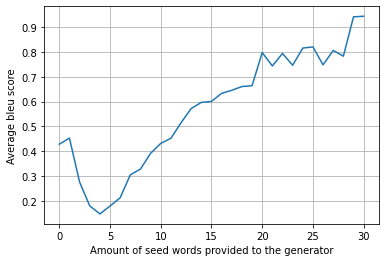

In [ ]:
bleu_averages=[]
for i in all_bleus:
  if(len(i)!=0):
    bleu_averages.append(sum(i)/len(i))

plt.plot(bleu_averages)
plt.xlabel("Amount of seed words provided to the generator")
plt.ylabel("Average bleu score")
plt.grid(True)

In [ ]:
print(sum(all_bleus)/len(all_bleus))

In [ ]:
#print(generator_object.generator_model.evaluate({"labels": classification_onehots[1000:2000],"sequences":token_list_states[:1000]}, token_actions[1000:2000]))
print(gan_object.get_average_score(generated_values[0], generated_values[1]))

In [ ]:
!unzip tweet_emotions.csv.zip

In [ ]:
!unzip archive.zip